In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from pandas.plotting import scatter_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
data_path = "./harth"

In [4]:
csv_files = glob.glob(os.path.join(data_path, '*.csv'))

# Iterate over each CSV file and print the unique label counts
for csv_file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Ensure the 'label' column exists in the DataFrame
    if 'label' in df.columns:
        # Get unique values and their counts
        unique_labels = df['label'].value_counts()
        unique_values = df['label'].unique()
        
        # Print the filename and unique label counts
        print(f"File: {os.path.basename(csv_file)}")
        print("Unique labels and their counts:")
        print(len(unique_values))
        print(unique_values)
        print(unique_labels)
        print()
    else:
        print(f"File: {os.path.basename(csv_file)} does not contain a 'label' column.")

File: S029.csv
Unique labels and their counts:
10
[  6   3   7   8   1   5   4  13 130   2]
label
1      121460
2       17774
6       12177
13      10443
3        5702
8        4842
7        3406
130      1590
5         936
4         386
Name: count, dtype: int64

File: S018.csv
Unique labels and their counts:
11
[  6   3   1   7   5  14  13 130   2   4   8]
label
7      142775
1       62810
6       38722
8       32872
3       16058
2       13782
13       6036
4        4024
5        3586
14       1456
130       150
Name: count, dtype: int64

File: S020.csv
Unique labels and their counts:
11
[  6   3   1   7   5   4   8  13 130  14   2]
label
7      236956
8       46952
1       35120
6       19974
13      14550
3        7572
2        3740
4        3018
5        2374
130       670
14        570
Name: count, dtype: int64

File: S009.csv
Unique labels and their counts:
9
[  6   1   4   3  13  14 130 140   5]
label
13     120101
14      10926
130     10375
6        6080
1        5676
5     

In [5]:
# Convert csv files to dataframes
df_25 = pd.read_csv(os.path.join(data_path, 'S025.csv'))
df_26 = pd.read_csv(os.path.join(data_path, 'S026.csv'))

df = pd.concat([df_25, df_26], ignore_index=True)

In [6]:
unique_labels = df['label'].value_counts()
print("Unique labels and their counts:")
print(unique_labels)

Unique labels and their counts:
label
13     150193
1       91674
2       45716
14      33244
8       20262
6       18483
130     14095
7       13186
5       12140
4       11157
3       10416
140      6335
Name: count, dtype: int64


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426901 entries, 0 to 426900
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  426901 non-null  object 
 1   back_x     426901 non-null  float64
 2   back_y     426901 non-null  float64
 3   back_z     426901 non-null  float64
 4   thigh_x    426901 non-null  float64
 5   thigh_y    426901 non-null  float64
 6   thigh_z    426901 non-null  float64
 7   label      426901 non-null  int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 26.1+ MB


In [8]:
nan_counts = df.isna().sum()
print("Count of NaN values in each column:")
print(nan_counts)

Count of NaN values in each column:
timestamp    0
back_x       0
back_y       0
back_z       0
thigh_x      0
thigh_y      0
thigh_z      0
label        0
dtype: int64


In [9]:
numeric_df = df.select_dtypes(include=[np.number])

# Now apply np.isinf() on this filtered DataFrame
inf_counts = np.isinf(numeric_df).sum()
print("Count of infinite values in each numeric column:")
print(inf_counts)

Count of infinite values in each numeric column:
back_x     0
back_y     0
back_z     0
thigh_x    0
thigh_y    0
thigh_z    0
label      0
dtype: int64


In [10]:
null_counts = df.isnull().sum()
print(null_counts)

timestamp    0
back_x       0
back_y       0
back_z       0
thigh_x      0
thigh_y      0
thigh_z      0
label        0
dtype: int64


In [11]:
df.describe()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
count,426901.000000,426901.000000,426901.000000,426901.000000,426901.000000,426901.000000,426901.000000
mean,-0.880159,-0.119372,-0.373908,-0.926960,-0.140718,-0.370446,13.638181
std,0.426412,0.179313,0.405916,0.641730,0.332106,0.694643,27.306890
min,-5.766602,-3.100098,-4.011719,-8.000000,-6.424316,-8.000000,1.000000
25%,-1.015625,-0.203125,-0.656494,-1.203125,-0.264893,-0.842285,2.000000
50%,-0.891113,-0.107178,-0.440674,-0.965576,-0.136719,-0.354980,8.000000
75%,-0.734619,-0.010742,-0.197998,-0.530273,0.001221,0.057129,13.000000
max,1.187988,2.296631,2.609131,7.999756,7.948730,7.999756,140.000000


In [12]:
df.shape

(426901, 8)

In [13]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [14]:
df.head()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-0.962158,-0.267822,-0.118164,-0.826172,-0.075684,0.388916,3
1,2019-01-12 00:00:00.020,-0.927979,-0.263184,-0.095459,-0.804688,-0.064453,0.193848,3
2,2019-01-12 00:00:00.040,-0.908691,-0.250732,-0.158447,-1.052246,-0.023926,-0.156982,3
3,2019-01-12 00:00:00.060,-0.962402,-0.231934,-0.238525,-1.263672,-0.026123,-0.233887,3
4,2019-01-12 00:00:00.080,-1.003906,-0.079834,-0.204590,-1.139648,0.516113,0.188232,3


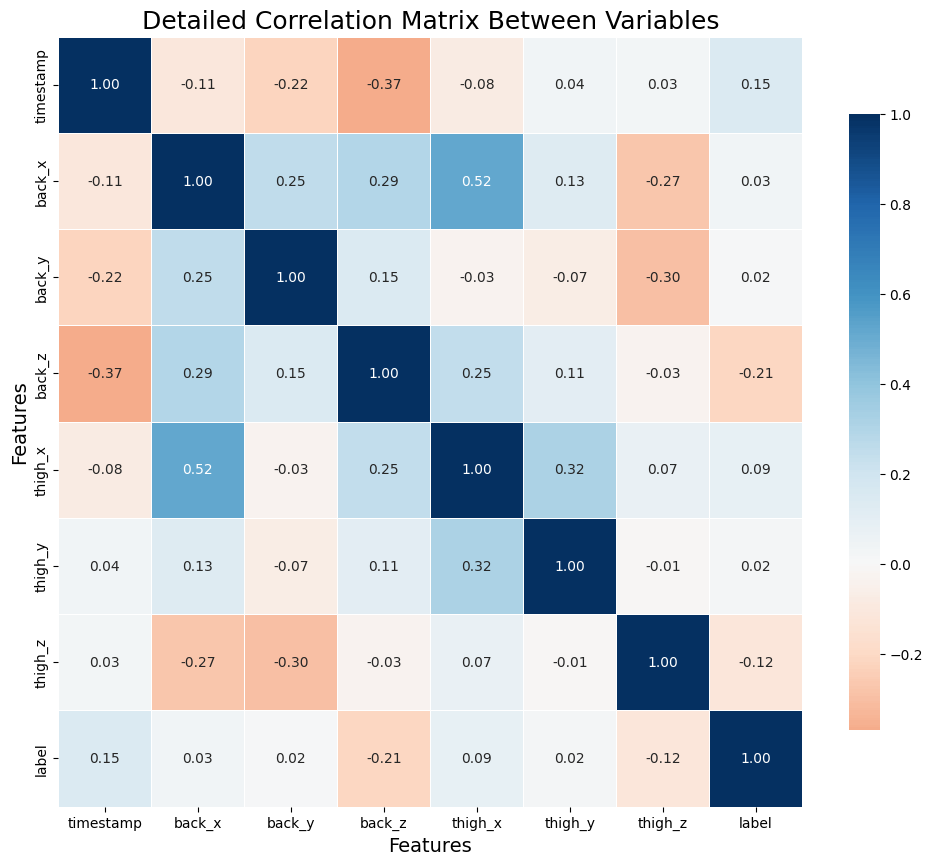

In [ ]:
plt.figure(figsize=(12,10))  # Adjust the figure size for better readability
correlation_matrix = df.corr()

# Create a heatmap with annotations
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="RdBu", center=0, linewidths=0.5, linecolor='white', cbar_kws={"shrink": 0.8})

# Add titles and labels for better context
plt.title("Detailed Correlation Matrix Between Variables", size=18)
plt.xlabel("Features", size=14)
plt.ylabel("Features", size=14)

# Show the plot
plt.show()

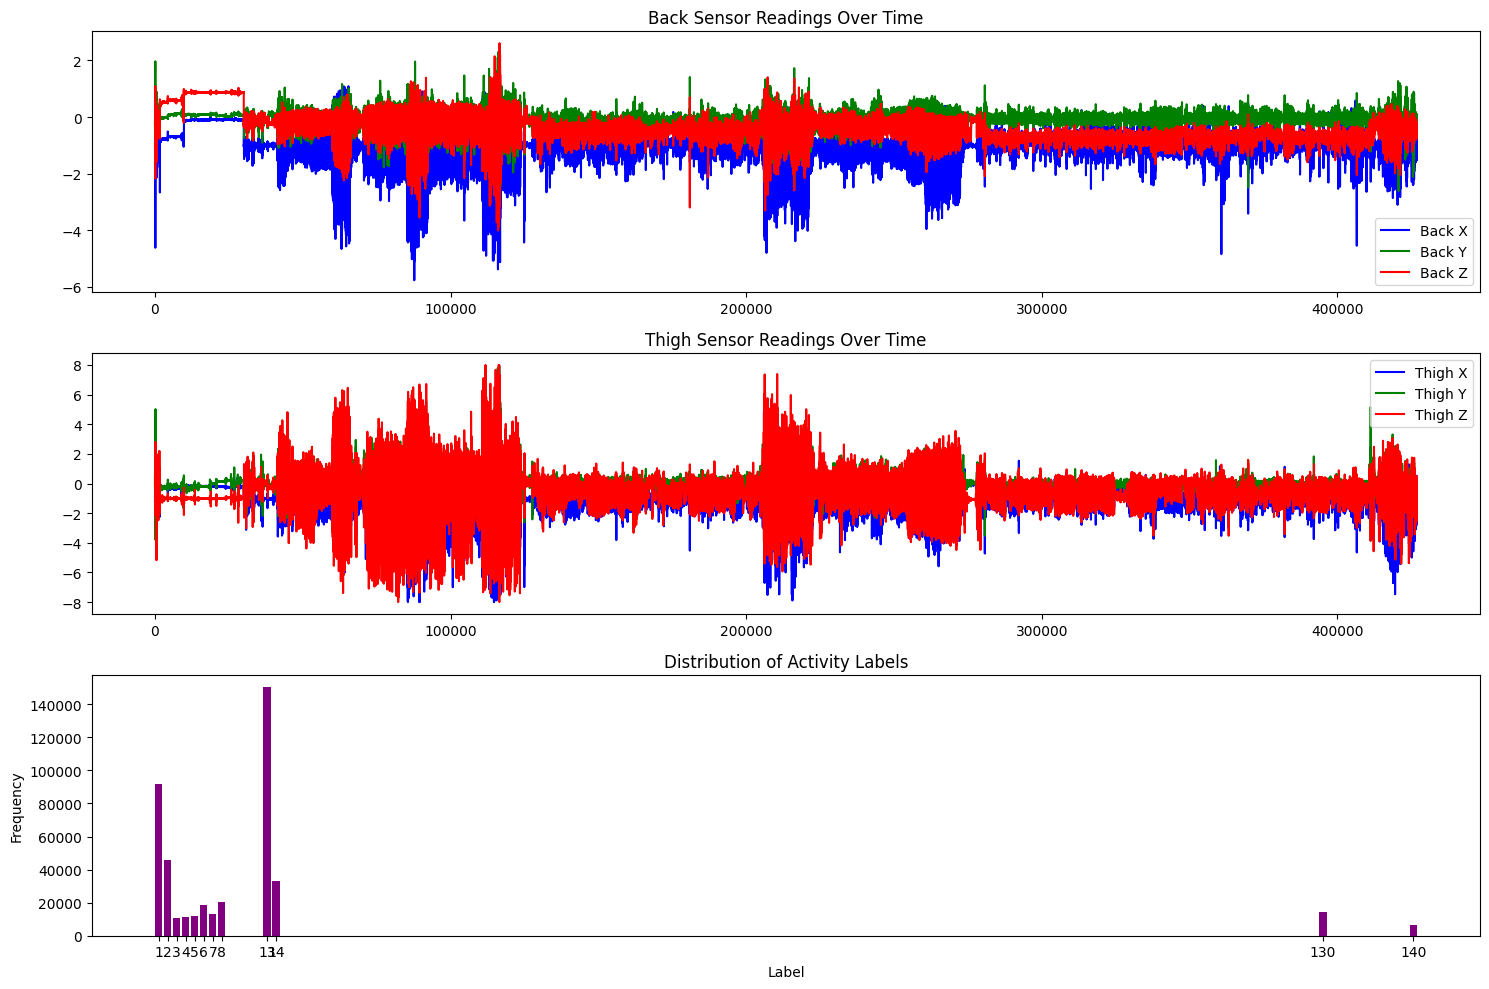

In [24]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df['back_x'].iloc[:426901], label='Back X', color='b')
plt.plot(df['back_y'].iloc[:426901], label='Back Y', color='g')
plt.plot(df['back_z'].iloc[:426901], label='Back Z', color='r')
plt.title('Back Sensor Readings Over Time')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df['thigh_x'].iloc[:426901], label='Thigh X', color='b')
plt.plot(df['thigh_y'].iloc[:426901], label='Thigh Y', color='g')
plt.plot(df['thigh_z'].iloc[:426901], label='Thigh Z', color='r')
plt.title('Thigh Sensor Readings Over Time')
plt.legend()

plt.subplot(3, 1, 3)
labels, counts = df['label'].value_counts().index, df['label'].value_counts().values
plt.bar(labels, counts, color='purple')
plt.title('Distribution of Activity Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(labels)

plt.tight_layout()
plt.show()

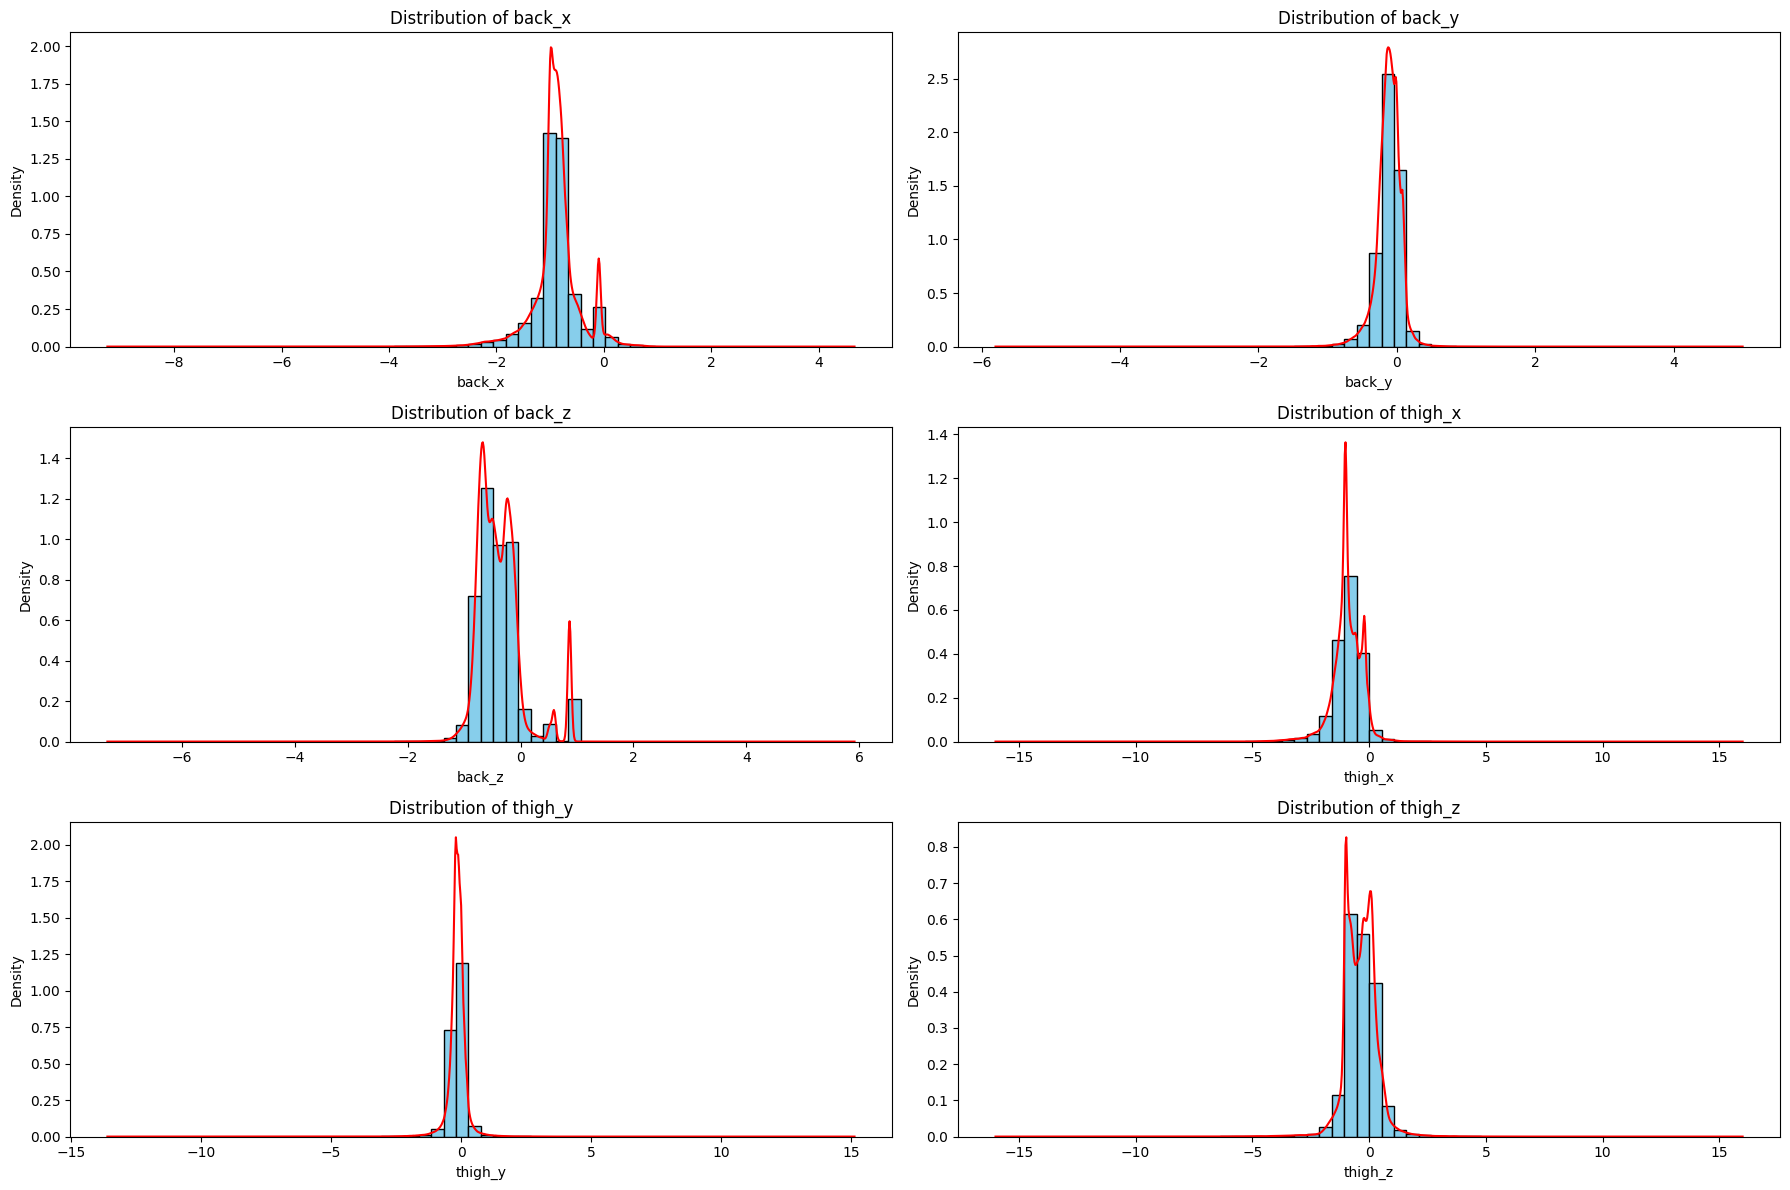

In [17]:
plt.figure(figsize=(18, 12))

sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
for i, column in enumerate(sensor_columns, 1):
    plt.subplot(3, 2, i)
    plt.hist(df[column].dropna(), bins=30, color='skyblue', edgecolor='black', density=True)
    df[column].dropna().plot(kind='kde', color='red', ax=plt.gca())
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

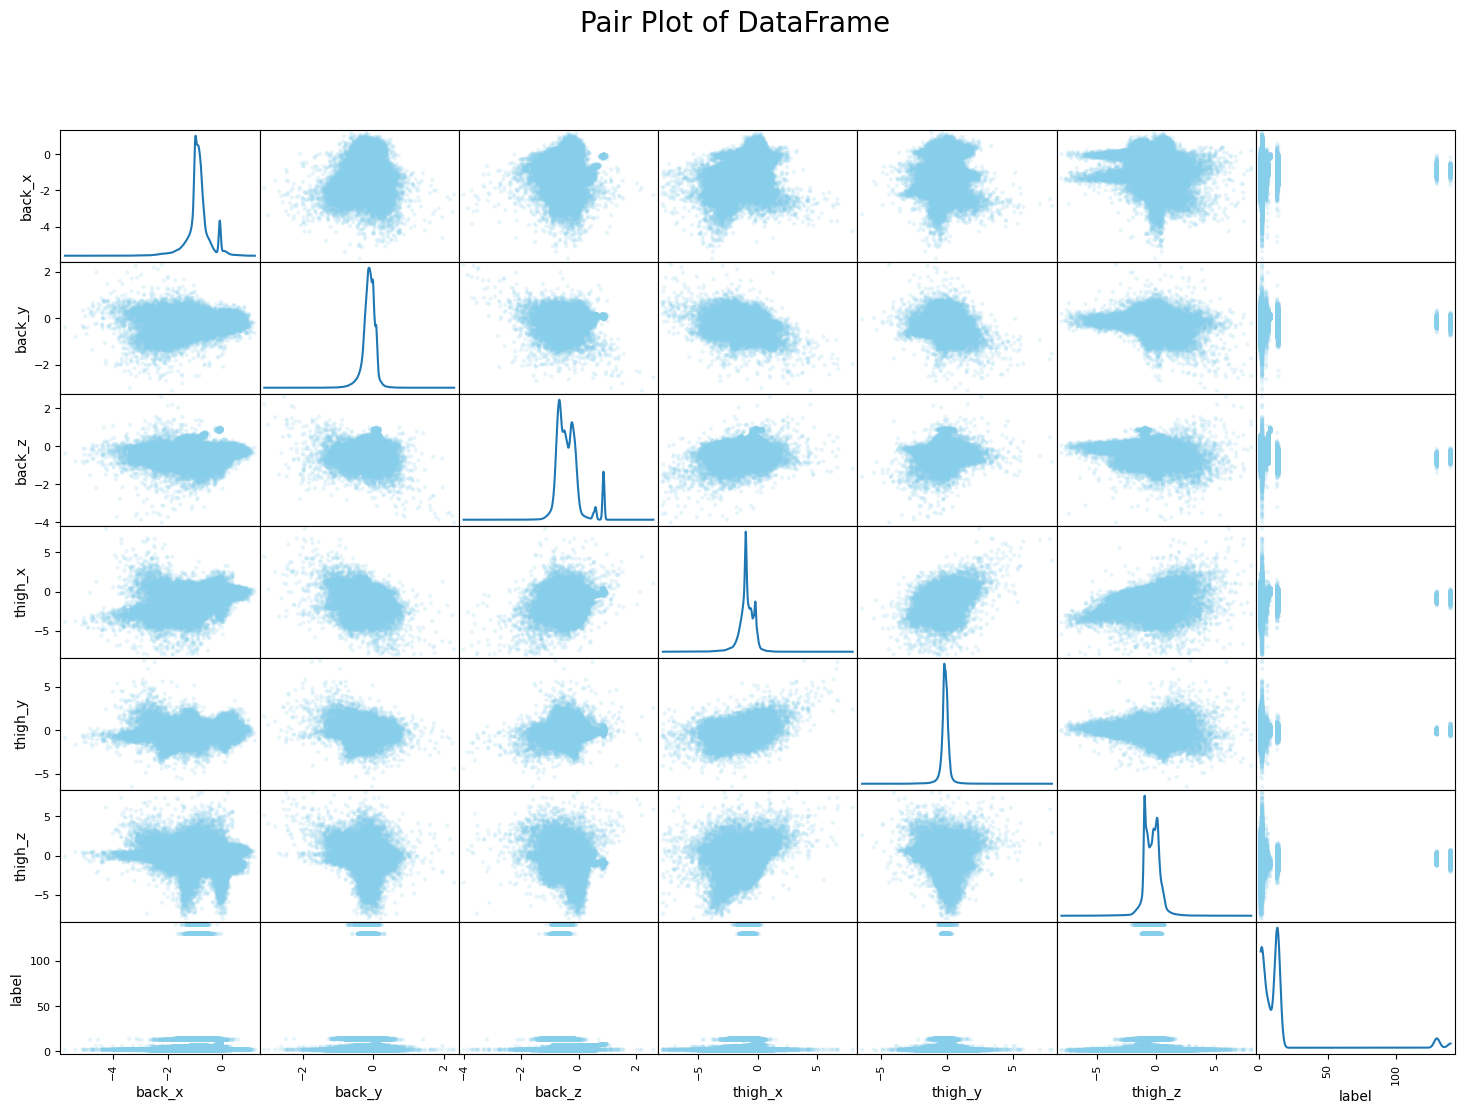

In [18]:
scatter_matrix(df, alpha=0.2, figsize=(18, 12), diagonal='kde', color='skyblue')

plt.suptitle('Pair Plot of DataFrame', size=20)
plt.show()

In [19]:
features = df[['thigh_x', 'thigh_y', 'thigh_z', 'back_x', 'back_y', 'back_z']].dropna()
target = df['label'][features.index]  # Ensure alignment of features and target

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Define classification models
models_classification = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'k-NN': KNeighborsClassifier(n_neighbors=13),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Naive Bayes': GaussianNB(),
    'MLP Classifier': MLPClassifier(random_state=42, max_iter=1000)
}

# Train, predict, and evaluate classification models
print("\nClassification Models:")
y_train_class = y_train.astype('int')  # Ensure target is in integer format
y_test_class = y_test.astype('int')  # Ensure target is in integer format

for name, model in models_classification.items():
    model.fit(X_train, y_train_class)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test_class, predictions)
    precision = precision_score(y_test_class, predictions, average='weighted')
    recall = recall_score(y_test_class, predictions, average='weighted')
    f1 = f1_score(y_test_class, predictions, average='weighted')
    cm = confusion_matrix(y_test_class, predictions)
    print(f"\n{name} - Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)


Classification Models:

Decision Tree - Accuracy: 0.8031
Precision: 0.8041
Recall: 0.8031
F1 Score: 0.8036
Confusion Matrix:
[[14613   553   828   591   759   338    11     0   417   268    13    31]
 [  513  8105    32    31   169     9     1     0   145    88     3     1]
 [  822    37   672    90    71   292     4     0    61    43     5    10]
 [  560    20    84  1070    87    35     1     0   293    57    19    12]
 [  737   183    96    83  1131    18     5     0   226    33     1     5]
 [  325     2   296    22    18  2946    11     0    18    38    13     4]
 [   10     1     7     4     1    11  2567     0    12     2     1     1]
 [    0     0     0     0     0     0     0  3953     0     0     0     0]
 [  425   142    80   328   225    20    17     0 26476  1002   988   320]
 [  243    82    59    75    32    42     0     0  1025  4864    99   231]
 [   16     2    11    18     5    13     0     0  1015    65  1560    47]
 [   24     5    14    16     6    10     0     0

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Logistic Regression - Accuracy: 0.6092
Precision: 0.4892
Recall: 0.6092
F1 Score: 0.5168
Confusion Matrix:
[[15222  1034     0     0     7   122   130     0  1626   279     2     0]
 [ 5537   604     0     0    36    70   283     2  1748   768    41     8]
 [ 1909    15     0     0     0     3    13     1   142    24     0     0]
 [ 1509    43     0     0     0     0     9     0   646    31     0     0]
 [ 2165    28     0     0     4     0     7     0   299    15     0     0]
 [ 3469     0     0     0     0     0    15     0   199    10     0     0]
 [   62     1     0     0     0     0  2153     0   401     0     0     0]
 [    0     0     0     0     0     0     0  3953     0     0     0     0]
 [  903    35     0     0     0     0    30     0 28890   165     0     0]
 [ 1112   155     0     0     0     0     1     0  4292  1192     0     0]
 [  136     3     0     0     0     0     0     0  2561    52     0     0]
 [  595    39     0     0     0     0     0     0   479    96     0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Naive Bayes - Accuracy: 0.6722
Precision: 0.6510
Recall: 0.6722
F1 Score: 0.6478
Confusion Matrix:
[[10815  2034   484   275     0  3881     1     0   542   363     0    27]
 [ 2598  5962     5    25     0    59     0     0   140   308     0     0]
 [  390    14   105    19     0  1384     1     0   143    38     0    13]
 [  649    15    41   158     0   356     0     0   941    75     0     3]
 [ 1542   154    64    49     0   434     0     0   251    23     0     1]
 [  155     5    17     1     0  3359    22     0   114    17     0     3]
 [  123     3     0     0     0     1  2132     0   356     2     0     0]
 [    0    52     0     0     0     0     1  3900     0     0     0     0]
 [  959   287    10    94     0    92     4     0 27254   482   822    19]
 [  690   186     7     4     0   111     0     0  3096  2394    26   238]
 [    4     0     0     3     0    13     0     0  1831    10   873    18]
 [   39     0     4     6     0    68     0     0   559    10    82   441]]

In [20]:
window_size = 5
df['back_x_max'] = df['back_x'].rolling(window=window_size).max()
df['back_y_max'] = df['back_y'].rolling(window=window_size).max()
df['back_z_max'] = df['back_z'].rolling(window=window_size).max()
df['thigh_x_max'] = df['thigh_x'].rolling(window=window_size).max()
df['thigh_y_max'] = df['thigh_y'].rolling(window=window_size).max()
df['thigh_z_max'] = df['thigh_z'].rolling(window=window_size).max()

df['back_x_min'] = df['back_x'].rolling(window=window_size).max()
df['back_y_min'] = df['back_y'].rolling(window=window_size).max()
df['back_z_min'] = df['back_z'].rolling(window=window_size).max()
df['thigh_x_min'] = df['thigh_x'].rolling(window=window_size).max()
df['thigh_y_min'] = df['thigh_y'].rolling(window=window_size).max()
df['thigh_z_min'] = df['thigh_z'].rolling(window=window_size).max()

df['back_x_mean'] = df['back_x'].rolling(window=window_size).mean()
df['back_y_mean'] = df['back_y'].rolling(window=window_size).mean()
df['back_z_mean'] = df['back_z'].rolling(window=window_size).mean()
df['thigh_x_mean'] = df['thigh_x'].rolling(window=window_size).mean()
df['thigh_y_mean'] = df['thigh_y'].rolling(window=window_size).mean()
df['thigh_z_mean'] = df['thigh_z'].rolling(window=window_size).mean()

df['back_x_std'] = df['back_x'].rolling(window=window_size).std()
df['back_y_std'] = df['back_y'].rolling(window=window_size).std()
df['back_z_std'] = df['back_z'].rolling(window=window_size).std()
df['thigh_x_std'] = df['thigh_x'].rolling(window=window_size).std()
df['thigh_y_std'] = df['thigh_y'].rolling(window=window_size).std()
df['thigh_z_std'] = df['thigh_z'].rolling(window=window_size).std()

df['back_x_cm'] = df['back_x'].cumsum()
df['back_y_cm'] = df['back_y'].cumsum()
df['back_z_cm'] = df['back_z'].cumsum()
df['thigh_x_cm'] = df['thigh_x'].cumsum()
df['thigh_y_cm'] = df['thigh_y'].cumsum()
df['thigh_z_cm'] = df['thigh_z'].cumsum()

df['back_x_diff'] = df['back_x'].diff()
df['back_y_diff'] = df['back_y'].diff()
df['back_z_diff'] = df['back_z'].diff()
df['thigh_x_diff'] = df['thigh_x'].diff()
df['thigh_y_diff'] = df['thigh_y'].diff()
df['thigh_z_diff'] = df['thigh_z'].diff()

In [21]:
features = df[['back_x_mean', 'back_y_mean', 'back_z_mean', 'thigh_x_mean', 'thigh_y_mean', 'thigh_z_mean',
               'back_x_std', 'back_y_std', 'back_z_std', 'thigh_x_std', 'thigh_y_std', 'thigh_z_std',
               'back_x_cm', 'back_y_cm', 'back_z_cm', 'thigh_x_cm', 'thigh_y_cm', 'thigh_z_cm',
               'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z','back_z_max', 'back_x_max', 'back_y_max', 'thigh_x_max', 'thigh_y_max'
              ,'thigh_z_max', 'back_x_min', 'back_y_min', 'back_z_min', 'thigh_x_min', 'thigh_y_min', 'thigh_z_min', 'back_x_diff',
               'back_y_diff', 'back_z_diff', 'thigh_x_diff', 'thigh_y_diff', 'thigh_z_diff']].dropna()
target = df['label'][features.index]  # Ensure alignment of features and target

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate the metrics for test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm1 = confusion_matrix(y_test, y_pred)

# Calculate the train set scores
test_accuracy = accuracy_score(y_test, y_pred)
test_precision_macro = precision_score(y_test, y_pred, average='macro')
test_recall_macro = recall_score(y_test, y_pred, average='macro')
test_f1_macro = f1_score(y_test, y_pred, average='macro')
test_precision_weighted = precision_score(y_test, y_pred, average='weighted')
test_recall_weighted = recall_score(y_test, y_pred, average='weighted')
test_f1_weighted = f1_score(y_test, y_pred, average='weighted')
test_cm = confusion_matrix(y_test, y_pred)


    # Print the scores
print('Test Accuracy:', test_accuracy)
print('Test Precision (Macro):', test_precision_macro)
print('Test Recall (Macro):', test_recall_macro)
print('Test F1-score (Macro):', test_f1_macro)
print('Test Precision (Weighted):', test_precision_weighted)
print('Test Recall (Weighted):', test_recall_weighted)
print('Test F1-score (Weighted):', test_f1_weighted)
print('Confusion-matrix:\n', test_cm)

Test Accuracy: 0.9926680721480441
Test Precision (Macro): 0.9915827367464449
Test Recall (Macro): 0.9851870993046553
Test F1-score (Macro): 0.9883170236510949
Test Precision (Weighted): 0.9926738533306331
Test Recall (Weighted): 0.9926680721480441
Test F1-score (Weighted): 0.9926426001459817
Confusion-matrix:
 [[18260     9     4    29    40     7     0     0     3     0     0     0]
 [   11  9102     0     0     0     0     0     0     0     0     0     0]
 [   55     0  2001    10    11    38     0     0     1     5     0     1]
 [   16     0     6  2171     5     1     0     0     2     0     0     0]
 [   25     0     5     2  2450     0     0     0     0     0     0     0]
 [   19     0    14     0     0  3692     0     0     6     0     0     0]
 [    0     0     0     0     0     0  2622     0     0     0     0     0]
 [    0     0     0     0     0     0     0  3952     0     0     0     0]
 [    0     0     0     0     0     0     0     0 30094    28    16     0]
 [    1     0

Feature ranking:
1. Feature back_x_cm (0.06506676388717299)
2. Feature thigh_x_cm (0.05811707684299624)
3. Feature back_y_cm (0.05317916308701639)
4. Feature back_z_mean (0.051744696598307605)
5. Feature back_z_max (0.051628047082331825)
6. Feature back_z_min (0.05131181138072503)
7. Feature back_z_cm (0.051054964189883166)
8. Feature thigh_y_cm (0.04823961077977977)
9. Feature back_z (0.04499359309678297)
10. Feature thigh_z_cm (0.04089384290937611)
11. Feature thigh_z_min (0.03638671594804626)
12. Feature back_x_min (0.03588062386752314)
13. Feature back_x_max (0.03511605561525985)
14. Feature thigh_z_max (0.03363394480734129)
15. Feature back_x_mean (0.032863010721466045)
16. Feature thigh_x_mean (0.0283171524963869)
17. Feature back_x_std (0.026134399859365914)
18. Feature thigh_z_mean (0.024899393063651704)
19. Feature thigh_x_std (0.023811211729731975)
20. Feature thigh_x_max (0.020570549222831237)
21. Feature back_x (0.02006911219331513)
22. Feature thigh_x_min (0.01955418963263

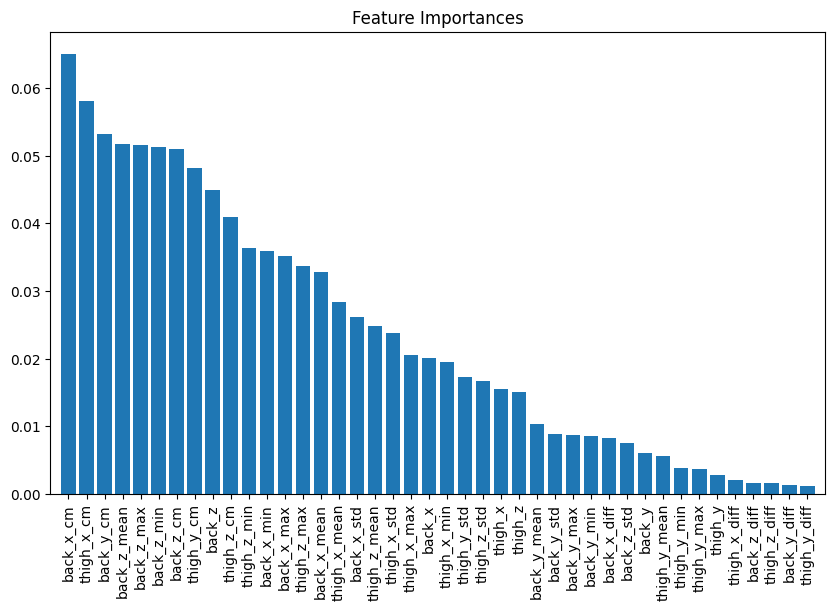

In [22]:
features = df[['back_x_mean', 'back_y_mean', 'back_z_mean', 'thigh_x_mean', 'thigh_y_mean', 'thigh_z_mean',
               'back_x_std', 'back_y_std', 'back_z_std', 'thigh_x_std', 'thigh_y_std', 'thigh_z_std',
               'back_x_cm', 'back_y_cm', 'back_z_cm', 'thigh_x_cm', 'thigh_y_cm', 'thigh_z_cm',
               'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z','back_z_max', 'back_x_max', 'back_y_max', 'thigh_x_max', 'thigh_y_max'
              ,'thigh_z_max', 'back_x_min', 'back_y_min', 'back_z_min', 'thigh_x_min', 'thigh_y_min', 'thigh_z_min', 'back_x_diff',
               'back_y_diff', 'back_z_diff', 'thigh_x_diff', 'thigh_y_diff', 'thigh_z_diff']].dropna()

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for i in range(len(indices)):
    print(f"{i + 1}. Feature {features.columns[indices[i]]} ({importances[indices[i]]})")

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), features.columns[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.show()

Test Accuracy: 0.9881236823612087
Test Precision (Macro): 0.9862826372171134
Test Recall (Macro): 0.9768939973516481
Test F1-score (Macro): 0.9813551446575969
Test Precision (Weighted): 0.9881554411876203
Test Recall (Weighted): 0.9881236823612087
Test F1-score (Weighted): 0.9880476971244416


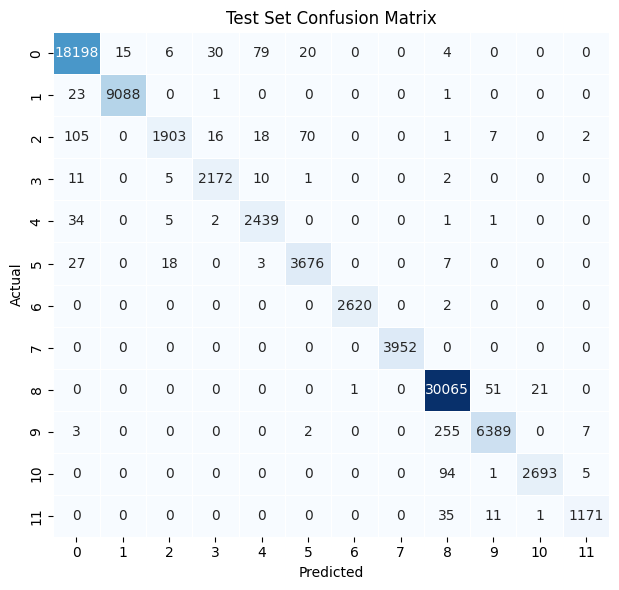

Train Accuracy: 1.0
Train Precision (Macro): 1.0
Train Recall (Macro): 1.0
Train F1-score (Macro): 1.0
Train Precision (Weighted): 1.0
Train Recall (Weighted): 1.0
Train F1-score (Weighted): 1.0


In [23]:
features = df[['thigh_z_mean', 'thigh_z', 'thigh_x', 'thigh_x_mean', 'thigh_x_min', 'thigh_z_max',
               'thigh_x_max', 'thigh_z_min', 'thigh_y_std', 'back_z_mean', 'thigh_x_std', 'back_z_max',
               'back_z', 'thigh_z_std', 'back_z_min', 'back_x_std', 'back_y_std', 'back_x_cm',
               'thigh_x_cm', 'back_z_cm']].dropna()
target = df['label'][features.index]  # Ensure alignment of features and target

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Train the model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Make predictions for test set
y_test_pred = model.predict(X_test)

# Make predictions for train set
y_train_pred = model.predict(X_train)

# Calculate the metrics for test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_precision_weighted = precision_score(y_test, y_test_pred, average='weighted')
test_recall_weighted = recall_score(y_test, y_test_pred, average='weighted')
test_f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
test_cm = confusion_matrix(y_test, y_test_pred)

# Calculate the metrics for train set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision_macro = precision_score(y_train, y_train_pred, average='macro')
train_recall_macro = recall_score(y_train, y_train_pred, average='macro')
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')
train_precision_weighted = precision_score(y_train, y_train_pred, average='weighted')
train_recall_weighted = recall_score(y_train, y_train_pred, average='weighted')
train_f1_weighted = f1_score(y_train, y_train_pred, average='weighted')

# Print the test set scores
print('Test Accuracy:', test_accuracy)
print('Test Precision (Macro):', test_precision_macro)
print('Test Recall (Macro):', test_recall_macro)
print('Test F1-score (Macro):', test_f1_macro)
print('Test Precision (Weighted):', test_precision_weighted)
print('Test Recall (Weighted):', test_recall_weighted)
print('Test F1-score (Weighted):', test_f1_weighted)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='white')
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Print the train set scores
print('Train Accuracy:', train_accuracy)
print('Train Precision (Macro):', train_precision_macro)
print('Train Recall (Macro):', train_recall_macro)
print('Train F1-score (Macro):', train_f1_macro)
print('Train Precision (Weighted):', train_precision_weighted)
print('Train Recall (Weighted):', train_recall_weighted)
print('Train F1-score (Weighted):', train_f1_weighted)